# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t+j}|w_{t+j-m})$$


$$ P(w_h | w_i) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = s^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

#### Imports

In [1]:
from skipgram import SkipGramBatcher, SingleMatrixSkipGram
import torch
import gc
import datetime
import pickle
import numpy as np
import pandas as pd
from utils import EmbeddingsEval

# for visualisation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#### Constants

In [2]:
# select whether to train model during this run or just load it from saved file
TRAIN = False

VOCAB_SIZE = 20000
BATCH_SIZE = 2048
EMBEDDINGS_DIM = 150
EPOCH_NUM = 2
WINDOW_SIZE = 3
LOGS_PERIOD = 15
MODEL_NAME = 'single_matrix'
np.random.seed(42)

#### Select device

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

if device.__str__() == 'cpu':
    tensor_type = torch.LongTensor
else:
    tensor_type = torch.cuda.LongTensor

print('using device:', device)
print(f'using {tensor_type} type')

using device: cpu
using <class 'torch.LongTensor'> type


#### Load corpus into batcher

In [4]:
text = []
with open('./data/text8', 'r') as text8:
    text = text8.read().split()

# text = ['first', 'used', 'against', 'early', 'working', 'radicals', 'including', 'class', 'other']
batcher = SkipGramBatcher(corpus=text, vocab_size=VOCAB_SIZE,
                          batch_size=BATCH_SIZE, window_size=WINDOW_SIZE,
                          drop_stop_words=True)
# free memory
text = []
gc.collect()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/DrMatters/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0

#### Create and train model

In [5]:
if TRAIN:
    loss_history = []
    corpus_size = len(batcher._corpus_indexes)

    model = SingleMatrixSkipGram(VOCAB_SIZE, EMBEDDINGS_DIM, device)
    loss_fun = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam([model.emb_matrix], lr=0.005)

In [6]:
if TRAIN:
    learning_started = datetime.datetime.now()

    cumulative_loss = 0
    for epoch in range(EPOCH_NUM):
        for i, (context, target) in enumerate(batcher):
            tensor_context = torch.from_numpy(context).type(tensor_type)
            tensor_target = torch.from_numpy(target).type(tensor_type)
            tensor_context.to(device)
            tensor_target.to(device)

            optimizer.zero_grad()
#             model.zero_grad()

            log_probs = model(tensor_context)
            loss = loss_fun(log_probs, tensor_target)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss

            if i % LOGS_PERIOD == 0:
                print(f'loss on {(i * BATCH_SIZE / corpus_size) * 100:.1f}%: ' + \
                      f'{(cumulative_loss / LOGS_PERIOD) :.7f}')
                
                loss_history.append(loss.data.cpu().numpy().item())
                cumulative_loss = 0
        
        # after every epoch we save:
                                    # the model
                                    # loss history
        learning_ended = datetime.datetime.now()
        learning_time = (learning_ended - learning_started).total_seconds()
        learning_ended = learning_ended.strftime("%H-%M %d-%m-%Y")

        torch.save(model, f'./models/{MODEL_NAME}(finished-{learning_ended})(epochs_completed-{epoch})(epoch_num-{EPOCH_NUM})' + \
                   f'(vocab-{VOCAB_SIZE})(batch-{BATCH_SIZE})' + \
                   f'(emb-{EMBEDDINGS_DIM})(wind-{WINDOW_SIZE})(consumed-{learning_time})'+ \
                   f'.pytorchmodel')

        with open(f'./data/loss/loss_{MODEL_NAME}(finished-{learning_ended})(epochs_completed-{epoch})(epoch_num-{EPOCH_NUM})' + \
                  f'(vocab-{VOCAB_SIZE})(batch-{BATCH_SIZE})' + \
                  f'(emb-{EMBEDDINGS_DIM})(wind-{WINDOW_SIZE})(consumed-{learning_time})'+ \
                  f'.pickle', 'wb') as f:
            pickle.dump(loss_history, f)
        print('Model saved succesfully')
        
        # quality evaluation
#         intrinsic_matrix = model.get_intrinsic_matrix()

#         emb_eval = EmbeddingsEval(intrinsic_matrix, words_to_tokens=batcher.words_to_tokens,
#                                   tokens_to_words=batcher.tokens_to_words)
        
#         for token_list in emb_eval.words_to_neighbors(['paris', 'energy', 'water', 'number']):
#             print(batcher.tokens_to_words(token_list))

#### Plotting loss

In [7]:
from utils import plot_moving_average

loss_file_location = './data/loss/loss_single_matrix(finished-17-49 06-03-2019)(epochs_completed-1)(epoch_num-2)(vocab-20000)(batch-2048)(emb-150)(wind-3)(consumed-635.876855).pickle'

with open(loss_file_location, 'rb') as f:
    loss_history = pickle.load(f)

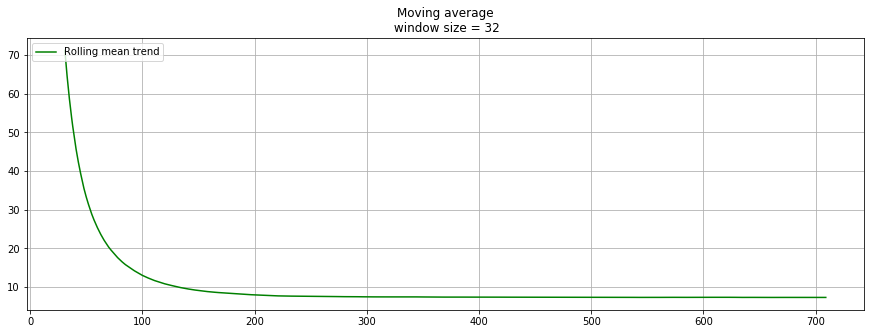

In [8]:
plot_moving_average(pd.Series(loss_history), 32, plot_actual=False)

#### Function to map token (and word) to corresponding word vector

In [9]:
model_file_location = './models/single_matrix(finished-17-49 06-03-2019)(epochs_completed-1)(epoch_num-2)(vocab-20000)(batch-2048)(emb-150)(wind-3)(consumed-635.876855).pytorchmodel'
model = torch.load(model_file_location, map_location='cpu')
model

/Users/DrMatters/anaconda3/envs/p_3_6/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'skipgram.SingleMatrixSkipGram' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


SingleMatrixSkipGram(
  (activation): LogSoftmax()
)

In [10]:
intrinsic_matrix = model.get_intrinsic_matrix()

emb_eval = EmbeddingsEval(intrinsic_matrix, words_to_tokens=batcher.words_to_tokens,
                          tokens_to_words=batcher.tokens_to_words)

Example of working methods to get embeddings by different indexes

In [11]:
emb_eval.tokens_to_embeddings([1, 2, 3])
emb_eval.words_to_embeddings(['integrity'])

array([[ 0.16328101,  0.25649056, -0.19342421, -0.28106165,  0.14800814,
         0.02218843,  0.28129852, -0.06788159, -0.8483854 ,  0.26013255,
        -0.29318532, -0.00799357,  0.19915074,  0.66861695, -0.14189656,
         0.20854671, -0.0172184 ,  0.5419667 , -0.10984892,  0.7539251 ,
         0.6009225 ,  0.0343891 , -0.3512227 ,  0.29331148, -0.65067315,
        -0.26069742,  0.22168085, -0.10074999, -0.01825043,  0.10460094,
        -0.6255966 ,  0.0946802 , -0.84749967, -0.09603462, -0.4263734 ,
        -0.5877903 ,  0.06170651,  0.35013908,  0.28835028, -0.8605544 ,
         0.553983  ,  0.3153274 , -0.63641614,  0.43890464, -0.30713692,
         0.25431633, -0.34505644,  0.2186276 , -0.22555597, -0.28099027,
        -0.04956223, -0.3613334 , -0.20809689,  0.39997968,  0.18884657,
        -0.20403065, -0.20346713, -0.2666178 , -0.6056987 , -0.1783029 ,
        -0.33735767, -0.48974347,  0.01102457,  0.08153486, -0.5050861 ,
        -0.16313212, -0.4303551 ,  0.25210312, -0.1

#### Beautiful visualizations (PCA)

In [12]:
num_words = 200
words = batcher.tokens_to_words(np.arange(0, num_words))
embeddings = emb_eval.tokens_to_embeddings(np.arange(0, num_words))

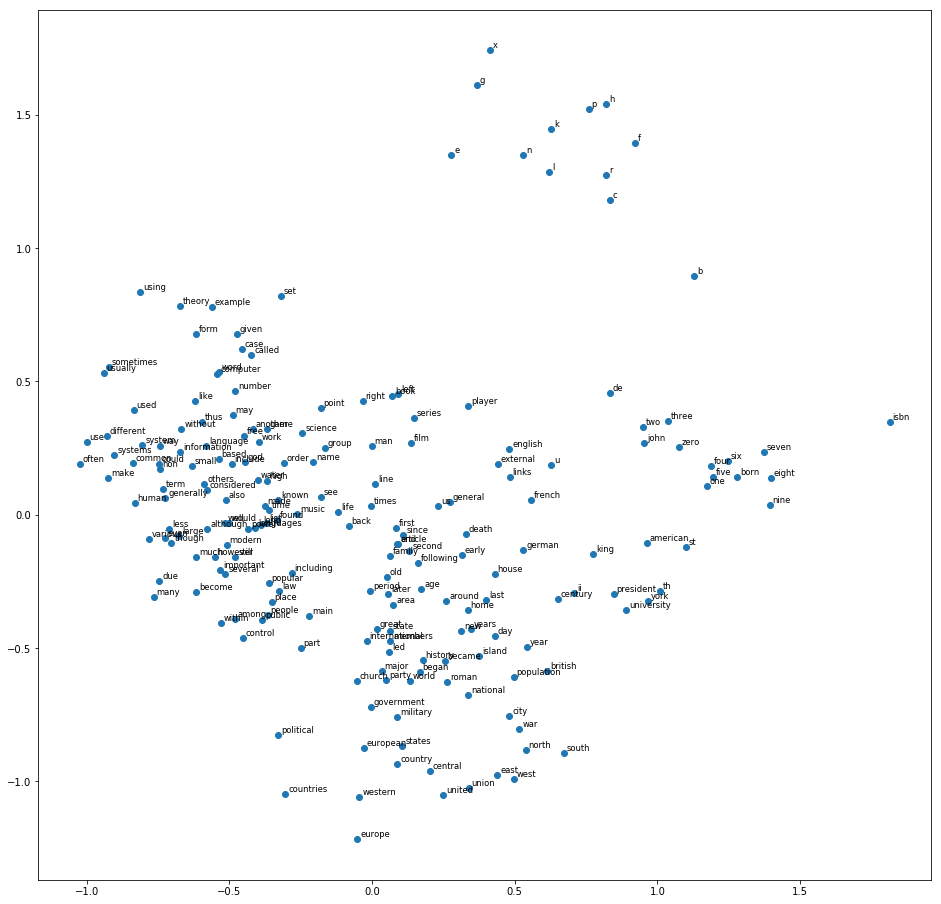

In [13]:
pca = PCA(n_components=2)
points2d = pca.fit_transform(embeddings)


fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(points2d[:, 0], points2d[:, 1])

for i, word in enumerate(words):
    ax.annotate(word, (points2d[i, 0] + 0.01, points2d[i, 1] + 0.01), fontsize='small')

#### qualitative evaluations of word vectors: nearest neighbors, word analogies

In [19]:
for token_list in emb_eval.words_to_neighbors(['spain', 'military', 'north']):
    print(batcher.tokens_to_words(token_list))

['france', 'portugal', 'spanish', 'italy', 'netherlands']
['forces', 'service', 'manpower', 'army', 'government']
['south', 'west', 'america', 'africa', 'east']


In [17]:
# ??? not found
similar = emb_eval.most_similar(positive=['madrid', 'france'], negative=['spain'])
similar

['acad', 'drunken', 'mie', 'madrid', 'aise']